### Сравнение bootstrap и Манна-Уитни:
____

![](me.jpeg)

Проведём ab test при этом мы уже знаем, что сплитование данных у нас прошло успешно и здесь мы не будем углубляться в подробности как правильно это делать ведь главная суть проекта состоит в том, чтобы как раз показать всю мощь bootstrap, а также сравнить его с таким критерием как непараметрический аналог t-test - критерий Манна-Уитни.
Если вы хотите погрузиться в мир A/B тестирования рекомендую прочитать вот [это](https://www.ozon.ru/product/doveritelnoe-a-v-testirovanie-224221240/?sh=RoJKJoWoEw).

### Немного теории:
____
Бутстрап — целое семейство методов, позволяющих проверять гипотезы с помощью повторных выборок.
То есть если у нас есть данные лишь о выборке мы можем оценить любой параметр в генеральной совокупности, но тогда напрашивается вопрос, а зачем нам вообще тогда  вся эта классическая статистика раз у нас есть такой крутой хипстерский метод ?
- Так как у bootstrap есть ограничения:
    1. Бутстрап не требует соблюдать предположения, но ему все еще требуется
        достаточно репрезентативная выборка.
    2. Чем выше количество бутстрап итераций, тем дольше придется ждать
        результат расчета.
    3. Чем исходная выборка, тем дольше придется ждать результат расчета.


Но если данные не очень большого размера (как раз как в нашем примере) или мы готовы ждать, то давайте же применим его:

In [5]:
#Для DataFrame:
import pandas as pd
import numpy as np

#Для визуализация:
import matplotlib.pyplot as plt
import seaborn as sns

#Для нашей функции:
from scipy.stats import norm
from tqdm.auto import tqdm

### План работы:
1. Изучить наши данные;
2. Применить критерий Манна-Уитни;
3. Применить bootstrap функцию.
____

### Задачи:
1. Сравните результат между тестом и контролем по двум кейсам:
Применить бутстрап (с np.mean) и критерий mann-whitney, бутстрап (с np.median), а потом сравните p-value.
2. Написать выводы данного эксперимента.

In [37]:
data = pd.read_csv("hw_bootstrap.csv",sep=";",usecols=["value","experimentVariant"])
data.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


Сначала проверим наши данные на NaN значения, типы данных и всё отфильтруем :

In [38]:
data.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [39]:
data.dtypes

value                object
experimentVariant    object
dtype: object

Как мы могли уже заметить, что в наших данных запятая вместо точки в цифровых значениях, а также нам стоит поменять тип данной колонки на float :

In [40]:
data["value"] = data["value"].str.replace(",",".")
data["value"] = data["value"].astype("float")
data.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


Далее разделим наш DataFrame на 2 группы и посмотрим на их распределения :

In [42]:
control = data.query("experimentVariant == 'Control'")
test = data.query("experimentVariant == 'Treatment'")
control.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


/home/onixx/anaconda3/envs/untitled/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


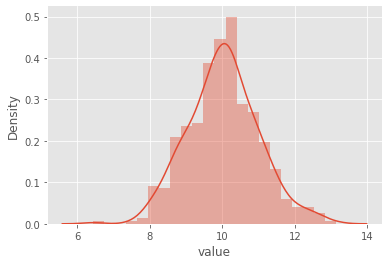

In [44]:
sns.histplot(control.value)
sns.despine()

/home/onixx/anaconda3/envs/untitled/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


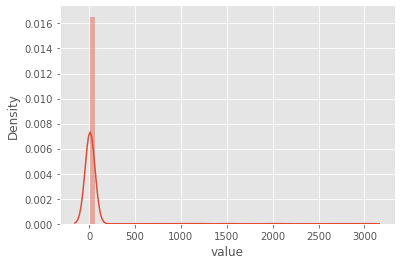

In [45]:
sns.histplot(test.value)
sns.despine()

Как мы видим, наша контрольная группа распределена относительно нормально, а что касаемо тестовой группы, здесь ситуация обратная, у нас здесь есть выбросы, поэтому я бы доверился бы медиане в данном случае.
Касаемо выбросов стоит учитывать, что в нашем тестовом датасете, мы их явно можем увидеть на графике, но бывают случаи, когда мы не можем их выкинуть, к примеру это наши VIP клиенты и тут в каждом случае стоит подходить индивидуально.
Также можно ознакомиться с доклада Яна[Методы обнаружения выбросов](https://www.youtube.com/watch?v=TOK7Kq7x0yc&list=PLo8_x3Axzvutlkh_ccSIvhJH7oBoLgOa_&index=4).

In [13]:
from pingouin import mwu
mwu(control["value"],test["value"])

,U-val,alternative,p-val,RBC,CLES
MWU,124189.5,two-sided,0.859215,0.006484,0.496758


In [14]:
from scipy.stats import mannwhitneyu
mannwhitneyu(control["value"],test["value"])

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Я специально проверил 2 разные библиотеки и они показали одинаковые значения p-value, которые подталкивают нас к принятию H0.
Но самая главная идея здесь, что данный критерий позволяет сравнить распределения и как они отличаются друг от друга:
Подробнее о интерпритации данного критерия можно почитать вот [тут](http://statistica.ru/local-portals/medicine/u-kriteriy-manna-uitni/).
Также сразу хочу предупредить, что данная функция была взята с данной [лекции](https://www.youtube.com/watch?v=-zps6hm0nX8) ещё хотелось бы добавить, что есть [альтернатива](https://pypi.org/project/bootstrapped/) данной функции, но лично мне удобнее использовать её.

In [46]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
        data_column_1, # числовые значения первой выборки
        data_column_2, # числовые значения второй выборки
        boot_it = 1000, # количество бутстрэп-подвыборок
        statistic = np.mean, # интересующая нас статистика
        bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)

    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

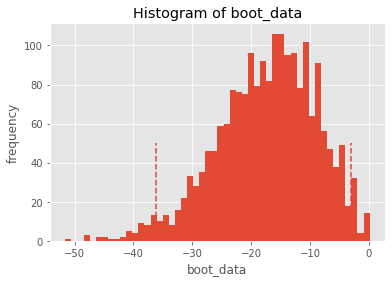

In [47]:
booted_data = get_bootstrap(control["value"], test["value"], boot_it = 2000)

In [48]:
booted_data["p_value"]

0.03779265404963428

In [49]:
booted_data["ci"]

,0
0.025,-36.124125
0.975,-3.012971


Исходя из данного результата можно утверждать, что разница между средними наблюдается и мы можем отклонить H0, так как в наш доверительный интревал значение 0 не входит, но так ли это на самом деле и давайте теперь проверим медиану, а после избавемся от выбросов в нашем DataFrame :

  0%|          | 0/2000 [00:00<?, ?it/s]

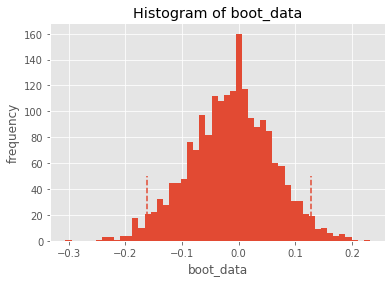

In [50]:
booted_data = get_bootstrap(control["value"], test["value"], boot_it = 2000,statistic=np.median)

А вот на счёт медианы мы можем сделать немного другие выводы, ведь теперь наш доверительный интервал входит в 0 и соответсвенно это позволяет нам принять H0.

In [51]:
booted_data["p_value"]

0.8502813512572842

In [52]:
booted_data["ci"]

,0
0.025,-0.161768
0.975,0.127454


Ну и финально давайте избавим наш датасет от выбросов и применим тот же самый bootstrap:

In [53]:
test.drop([995,996,997,998,999],axis=0,inplace = True)

/tmp/ipykernel_60430/3161429918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop([995,996,997,998,999],axis=0,inplace = True)


  0%|          | 0/2000 [00:00<?, ?it/s]

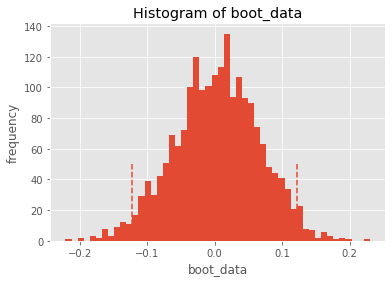

In [54]:
booted_data = get_bootstrap(control["value"], test["value"], boot_it = 2000)

### Выводы:
____
 - В данном случае я бы лучше доверился результатам p-value медианы bootstrap, так как мы явно можем заметить выбросы в наших значениях и я принимаю H0.
 - Стоит заметить, что как только мы убрали 5 выбросов, наш bootstrap показал нормальный результат.

### Ссылки на дополнительное изучение:
____
1. [Главная идея bootstrap](https://www.youtube.com/watch?v=Xz0x-8-cgaQ);
2. [Bootstrap: виды, особенности, ограничения и способы применения](https://www.youtube.com/watch?v=8CMV5cK83ns);
3. [Карта статистических методов - bootstrap VS t - test](https://www.youtube.com/watch?v=-zps6hm0nX8);
4. [Краткий ввод в различные виды bootstrap](https://www.researchgate.net/publication/37434447_Bootstrap_Methods_and_Their_Application);
5. [Классный доклад про доверительные интервалы в bootstrap](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf);
6. [Классная книжка про A/B тесты](https://www.ozon.ru/product/doveritelnoe-a-v-testirovanie-224221240/?sh=RoJKJoWoEw);
7. [Методы обнаружения выбросов](https://www.youtube.com/watch?v=TOK7Kq7x0yc&list=PLo8_x3Axzvutlkh_ccSIvhJH7oBoLgOa_&index=4).

![](final_picture.jpg)